In [1]:
## custom
import utils, vis
import criteria as C


## third party
import networkx as nx
import poly_point_isect as bo   ##bentley-ottmann sweep line

from PIL import Image
from natsort import natsorted


## sys
import random
import time
from glob import glob
import math

## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from IPython.display import clear_output
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


## Optimize via Stochastic Gradient Descent (SGD)

In [2]:
def vertex_resolution(pos, sampleSize=None, target=0.1):
    pairwiseDistance = nn.PairwiseDistance()
    relu = nn.ReLU()
    softmax = nn.Softmax(dim=0)
    softmin = nn.Softmin(dim=0)
    
    n = pos.shape[0]
    if sampleSize is not None:
        i = np.random.choice(n, min(n,sampleSize), replace=False)
        samples = pos[i,:]
    else:
        samples = pos
    m = samples.shape[0]
    a = samples.repeat([1,m]).view(-1,2)
    b = samples.repeat([m,1])
    pdist = pairwiseDistance(a, b)
#     dmax = (softmax(pdist)*pdist).sum().detach()
    dmax = pdist.max().detach()
    targetDist = target*dmax
    
#     loss = len(pdist)*(softmin(pdist).detach() * relu((targetDist - pdist)/targetDist)).sum()
#     loss = relu((targetDist - pdist)/targetDist).sum()
    loss = relu(1 - pdist/targetDist).sum()
    return loss

In [3]:
# def tick(t0, msg=''):
#     t1 = time.time()
#     print(f'{msg}: {t1-t0}')
#     return t1


# def find_crossings(pos, G_edges, k2i):
    
#     ##TODO improve runtime
#     t0 = time.time()
#     x = pos.detach().cpu().numpy().tolist()
# #     t0 = tick(t0, 'a')
#     x = [(
#             tuple([*x[k2i[e0]], k2i[e0]]), ## (x, y, source id)
#             tuple([*x[k2i[e1]], k2i[e1]])  ## (x, y, target id) 
#         )
#         for e0,e1 in G_edges
#     ]
# #     t0 = tick(t0, 'b')
 
#     ## option 1
#     point_segs_pairs = bo.isect_segments_include_segments(x)
#     crossing_segs = np.array([psp[1] for psp in point_segs_pairs])
# #     t0 = tick(t0, 'c')
#     if len(crossing_segs) > 0:
#         crossing_segs = crossing_segs[:,:,:,2].reshape([crossing_segs.shape[0], -1])
#         crossing_segs = crossing_segs.astype(np.int)## indices of 4 nodes in edge crossing pairs
#         return crossing_segs
#     else:
#         return np.zeros([0,4])

# #     ## option 2 (faster)
# #     crossing_segs = []
# #     intersections = intersection(x)
# #     if intersections is not None:
# #         for l in list(intersections.values()):
# #             a,b,c,d = l[0][0][2], l[0][1][2], l[1][0][2], l[1][1][2]
# #             if a!=c and a!=d and b!=c and b!=d:
# #                 crossing_segs.append([a,b,c,d])
# #         crossing_segs = np.array(crossing_segs)
# #         return crossing_segs
# #     #     t0 = tick(t0, 'c')
# #     else:
# #         return np.zeros([0,4])
        


    
# def crossing_angle_maximization(pos, G, k2i, i2k, sampleSize, sampleOn='edges'):
#     edge_list = list(G.edges)
#     if sampleOn == 'edges':
#         sample_indices = np.random.choice(len(edge_list), sampleSize, replace=False)
#         edge_samples = [edge_list[i] for i in sample_indices]
#         crossing_segs_sample = find_crossings(pos, edge_samples, k2i)
        
#     elif sampleOn == 'crossings':
#         crossing_segs = find_crossings(pos, edge_list, k2i)
#         crossing_count = crossing_segs.shape[0]
#         sample_indices = np.random.choice(crossing_count, min(sampleSize,crossing_count), replace=False)
#         crossing_segs_sample = crossing_segs[sample_indices]

#     if len(crossing_segs_sample) > 0:
#         pos_segs = pos[crossing_segs_sample.flatten()].view(-1,4,2) #torch.stack([torch.stack([pos[i],pos[j],pos[k],pos[l]]) for i,j,k,l in crossing_segs_sample])
#         v1 = pos_segs[:,1] - pos_segs[:,0]
#         v2 = pos_segs[:,3] - pos_segs[:,2]
#         cosSim = torch.nn.CosineSimilarity()
#         return (cosSim(v1, v2)**2).sum()
#     else:
#         return (pos[0,0]*0).sum()##dummy loss
    
    
# def aspect_ratio(pos, sampleSize, 
#                  angles=torch.arange(7,dtype=torch.float)/7*np.pi*2, 
#                  target_width_to_height=[1,1], 
#                  scale=0.1):
    
#     if sampleSize is not None:
#         n = pos.shape[0]
#         i = np.random.choice(n, min(n,sampleSize), replace=False)
#         samples = pos[i,:]
#     else:
#         samples = pos
        
#     mean = samples.mean(dim=0, keepdim=True)
# #     print(mean)
#     samples -= mean
    
#     cos = torch.cos(angles)
#     sin = torch.sin(angles)
#     rot = torch.stack([cos, sin, -sin, cos], 1).view(len(angles), 2, 2)
    
#     samples = samples.matmul(rot)

#     softmax = nn.Softmax(dim=1)
#     max_hat = (softmax(samples*scale) * samples).sum(1)
#     min_hat = (softmax(-samples*scale) * samples).sum(1)
    
#     w = max_hat[:,0] - min_hat[:,0]
#     h = max_hat[:,1] - min_hat[:,1]
#     estimate = torch.stack([w,h], 1)
#     estimate /= estimate.sum(1, keepdim=True)
# #     print(estimate)
#     target = torch.tensor(target_width_to_height, dtype=torch.float)
#     target /= target.sum()
#     target = target.repeat(len(angles), 1)
#     bce = nn.BCELoss(reduction='mean')
#     return bce(estimate, target)

## test runtime

In [4]:
# delete old
# !rm -r fig
!mkdir fig

In [5]:
# crossings(pos, G, k2i, sampleSize=100)


In [6]:
# progress = crossings(pos, G, k2i, sampleSize=1000, debug=True)
# for res in progress:
#     loss = res['loss']
#     segs = res['segs']
#     pred = res['pred']
#     w,b = res['w'], res['b']


#     i = 0
#     xy = segs[i].detach()
#     bx = np.array([xy[:,0].min(), xy[:,0].max()])
#     by = (0 - w[i,0,0].detach()*bx - b[i,0,0].detach() )/w[i,1,0].detach()
#     by1 = (1 - w[i,0,0].detach()*bx - b[i,0,0].detach() )/w[i,1,0].detach()
#     by2 = (-1 - w[i,0,0].detach()*bx - b[i,0,0].detach() )/w[i,1,0].detach()
#     plt.subplot(121)
#     plt.plot(xy[:2,0], xy[:2,1], label='-1')
#     plt.plot(xy[2:,0], xy[2:,1], label='+1')
#     plt.legend()

#     plt.plot(bx, by, '--', c='C2')
#     plt.plot(bx, by1, '-', c='C2')
#     plt.plot(bx, by2, ':', c='C2')
#     plt.axis('equal')
    
#     plt.subplot(122)
#     plt.hist(pred.view(-1).detach(), bins=30)
#     plt.show()
    
#     print(w[i])



In [7]:
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# nx.draw_networkx(G, pos_i, with_labels=False, node_size=2, width=0.1)

In [54]:

def crossings(pos, G, k2i, sampleSize, sampleOn='edges', reg_coef=1, debug = False):
    crossing_segs_sample = utils.sample_crossings(pos, G, k2i, sampleSize, sampleOn)
    ## sample nodes, all its incident edges, and some other edges
#     i2k = {v:k for k,v in k2i.items()}
#     sample_indices = np.random.choice(len(G), min(sampleSize,len(G)), replace=False)
#     edge_samples = set()
#     for i in sample_indices:
#         neighbors = list(G.neighbors(i))
#         edge_samples.update([(i2k[i],n) for n in neighbors])
#     edge_samples = list(edge_samples)
#     print(edge_samples)
#     crossing_segs_sample = find_crossings(pos, edge_samples, k2i)
    
    if len(crossing_segs_sample) > 0:
        pos_segs = pos[crossing_segs_sample.flatten()].view(-1,4,2)
        w = (torch.rand(pos_segs.shape[0], 2, 1)-0.5).requires_grad_(True)
        b = (torch.rand(pos_segs.shape[0], 1, 1)-0.5).requires_grad_(True)
        relu = nn.ReLU()
        o = optim.SGD([w,b], lr=0.01, momentum=0.5, nesterov=True)
#         o = optim.SGD([w,b], lr=0.1)
        for _ in range(100):
            pred = pos_segs.detach() @ w + b
            ## assume labels of nodes in the first edges are -1
            ## now flip the pred of those nodes so that now we want every pred to be +1
            pred[:,:2,:] = -pred[:,:2,:]
            
            loss_svm = relu(1-pred).sum() + reg_coef * w.pow(2).sum()
            o.zero_grad()
            loss_svm.backward()
            o.step()
#             if debug:
#                 yield {
#                     'loss': loss_svm,
#                     'segs': pos_segs,
#                     'pred': pred,
#                     'w': w,
#                     'b': b,
#                 }
        pred = pos_segs @ w.detach() + b.detach()
#         print(pred)
    
        pred[:,:2,:] = -pred[:,:2,:] 
        loss_crossing = relu(1-pred).sum()
        return loss_crossing
        ## learn decision boundary for each seg pairs
        ## return loss to imporve decisions
    
    
    else:
        ##return dummy loss
        return (pos[0,0]*0).sum()

In [9]:
runtime = []

In [145]:
import importlib
C = importlib.reload(C)

In [122]:
# def gabriel(pos, G, k2i, sampleSize):
#     edges = utils.sample_edges(G, sampleSize)
#     nodes = utils.sample_nodes(G, sampleSize)
#     m,n = len(nodes), len(edges)
    
#     edges = np.array([(k2i[e0], k2i[e1]) for e0,e1 in edges])
#     nodes = np.array([k2i[n] for n in nodes])
#     node_pos = pos[nodes]
#     edge_pos = pos[edges.flatten()].reshape([-1,2,2])
#     centers = edge_pos.mean(1)
#     radii = (edge_pos[:,0,:] - edge_pos[:,1,:]).norm(dim=1, keepdim=True)/2
    
#     centers = centers.repeat(1,m).view(-1, 2)
#     radii = radii.repeat(1,m).view(-1, 1)
#     node_pos = node_pos.repeat(n,1)
    
#     relu = nn.ReLU()
# #     print((node_pos-centers).norm(dim=1))
#     loss = relu(radii - (node_pos-centers).norm(dim=1)).pow(2)
#     loss = loss.sum()
#     return loss
# gabriel(pos, G, k2i, 100)

tensor(93633.5703, grad_fn=<SumBackward0>)

In [140]:
int(sampleSize**0.5)

11

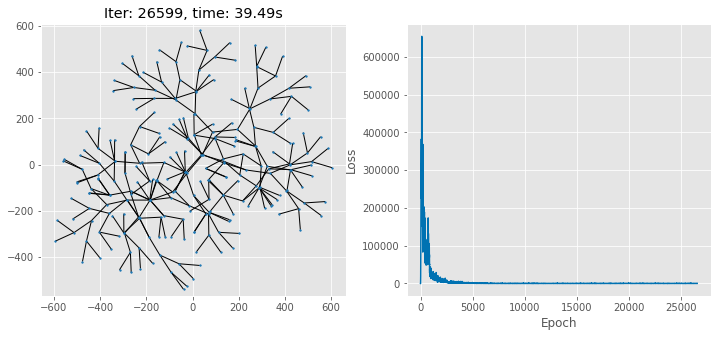

Epoch 26683: reducing learning rate of group 0 to 1.0000e-06.
Done


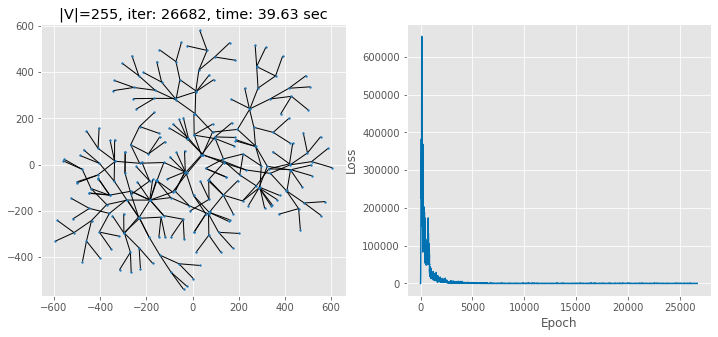

CPU times: user 2min 56s, sys: 6.48 s, total: 3min 2s
Wall time: 2min 45s


39.628923177719116

In [148]:
%%time

niter = int(1e6)

shouldVis = True
visIter = 100

shouldSnap = True
snapIter = 5

gClamp = 100
minLR = 1e-6
maxSampleSize = 128



totalTime = 0

print('generating graph', end=' ')
# G = nx.grid_2d_graph(5,5)
# G = nx.hypercube_graph(3)
G = nx.balanced_tree(2,7)
print(f'of {len(G)} nodes')

print('Calculating all pairs shortest path', end='...')
t0 = time.time()
D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
i2k = {i:k for k,i in k2i.items()}
dt = time.time() - t0
totalTime += dt

W = 1/(D**2+np.eye(len(G)))
truth = adj + torch.eye(adj.shape[0], device=device)
print('done')





##training
#     pos = torch.rand(len(G.nodes), 2, device=device)*2-1
pos = torch.randn(len(G.nodes), 2, device=device)
pos.requires_grad_(True)

optimizer = optim.SGD([pos], lr=0.05, momentum=0.9, nesterov=True)
# optimizer = optim.RMSprop([pos], lr=0.1)
patience = np.ceil(np.log2(len(G)))*100
# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=patience, 
                                                 min_lr=minLR, verbose=True)

iterBar = tqdm(range(niter))
lossCurve = []
sampleSize = min(len(G), maxSampleSize)
degrees = adj.sum(1).numpy().astype(np.int64)
xPath = []

for i in iterBar:
    t0 = time.time()
    optimizer.zero_grad()
#     loss = C.stress(pos, D, W, sampleSize)
#     loss = C.neighborhood_preseration(pos, G, adj, k2i, i2k, n_roots=2, depth_limit=2)
#     loss = C.edge_uniformity(pos, G, k2i, sampleSize-1)
#     loss = C.aspect_ratio(pos, sampleSize)
#     loss = C.crossing_angle_maximization(pos, G, k2i, i2k, sampleSize=10) ## slow for large sample size
#     loss = 100*C.vertex_resolution(pos, sampleSize, target=1/len(G)**0.5)
    loss = 0.1*C.gabriel(pos, G, k2i, sampleSize=int(sampleSize**0.5))
    
#     loss = 10*crossings(pos, G, k2i, sampleSize=10)
#         loss = 0.5 * C.angular_resolution(pos, G, k2i, sampleSize)## reyan's working on it
#     print(loss.item())
    
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()



    ##debug info
    dt = time.time() - t0
    totalTime += dt
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({
            'loss': loss.item(), 
        })
#     print(utils.find_crossings(pos, G.edges, k2i).shape[0])

    if len(lossCurve) > 0:
        lossCurve.append(0.9*lossCurve[-1] + 0.1*loss.item())
    else:
        lossCurve.append(loss.item())

    if scheduler is not None:
#         scheduler.step()
        scheduler.step(lossCurve[-1])

    if shouldSnap and i % snapIter == 0:
        x = pos.detach().cpu().numpy()
        xPath.append(x.copy())

    ##vis
    if shouldVis and i % visIter == visIter-1:
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossCurve, [], i, totalTime, edge=True, show=True, save=False)
        prevTime = totalTime
        
    if optimizer.param_groups[0]['lr'] <= minLR:
        print('Done')
        break

## show final result
x = pos.detach().cpu().numpy()   
pos_i = {k: x[k2i[k], :2] for k in G.nodes}
vis.plot(G, pos_i, lossCurve, [], i, totalTime,  
         show=True, save=True, title=f'|V|={len(G)}, iter: {i}, time: {totalTime:.2f} sec')
totalTime


In [12]:
crossings(pos, G, k2i, sampleSize=50)

tensor(2.7046e+27, grad_fn=<SumBackward0>)

In [13]:
# fig, ax = plt.subplots()

# nx.draw_networkx(G, pos_i, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## save fig

## Animation

In [57]:
len(xPath)

205

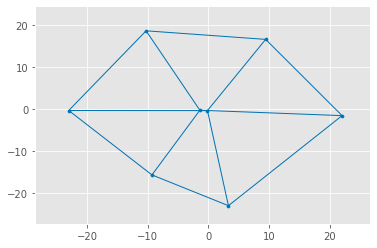

In [58]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

if type(xPath) == list:
    xPath = np.stack(xPath)
    
padding = 0.1

fig, ax = plt.subplots()
scatter = plt.scatter([0], [0], s=10)
lc = mc.LineCollection([], linewidths=1)
ax.add_collection(lc)

xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
    
def init():
    return scatter,lc

def update(frame):
    xy = xPath[frame]
    scatter.set_offsets(xy)
    segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
    lc.set_segments(segs)
    return scatter,lc

anim = FuncAnimation(
    fig, 
    update, 
    frames=range(0,len(xPath),1),
    init_func=init, 
    interval=1000.0/20,
    blit=True)

HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)